****************************************************************************************************************
./images/ 에 저장된 파일들에 상응하는 bb 및 keypoint를 시각화한 jpg 파일을 ./labeled/ 에 저장함. 
파일을 읽는 위치나 파일을 저장하는 위치를 바꾸고자 한다면 3번 셀에서 경로 변수에 바뀐 경로를 str으로 할당할 것. 

파일을 읽어들이는 순서대로 모든 tail_0, neck, <각 신체부위>의 각도를 계산해서 pd.DataFrame으로 합치고, ipynb 파일이 있는 위치와 동일한 디렉토리로
angle.json 파일로 저장함. 

last edit: 11/5/2022 윤기화

****************************************************************************************************************

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import pandas as pd

In [ ]:
keypoints_classes = {1:'fu', 
                     2:'hu', 
                     3:'neck', 
                     4:'nose', 
                     5:'spine', 
                     6:'tail_0', 
                     7:'tail_1', 
                     8:'tail_2', 
                     9:'tail_3', 
                     10:'tail_4', 
                     11:'tail_5'
                     }
                    
IMAGE_PATH = './images/'
JSON_PATH = './annotations/'
SAVE_LOC = './labeled/'
image_path = os.listdir(IMAGE_PATH)
json_path = os.listdir(JSON_PATH)

In [ ]:
def visualize_n_save(image_path, keypoints, bboxes, save=False):    
    connection_scheme = [(7, 8), (8, 9), (9, 10), (10, 11), (5, 3), (6, 5), (6, 7), (6, 2), (3, 1), (3, 4), (1, 2)]
    for i in range(len(bboxes)):
        top_left_corner, bottom_right_corner = tuple([bboxes[i][0], bboxes[i][1]]), tuple([bboxes[i][2], bboxes[i][3]])
        img = cv2.imread(image_path)
        img = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0, 255, 0), 3)

        centers = [tuple([kp[0], kp[1]]) for kp in keypoints[i]]
        for id, pt in enumerate(centers):
            img = cv2.circle(img, pt, 1, (255,0,0), 1)
            img = cv2.putText(img, " " + keypoints_classes[id + 1], pt, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    
        for conn in connection_scheme:
            cv2.line(img, keypoints[i][conn[0] - 1][:2], keypoints[i][conn[1] - 1][:2], (255, 0, 0), 1)
            cv2.imwrite(SAVE_LOC + f"{image_path}_labeled.jpg", img)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)


def track_point_coord(keypoints, keypoints_classes):
    p_dict = {} 
    for j in keypoints:
        p_dict[keypoints_classes[j[2]]]  = j[:2]
    return p_dict
                

def calculate_angle(pt1, pt2, pt3):
    a, b, c = np.array(pt1), np.array(pt2), np.array(pt3)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle


def get_angle_array(keypoints, keypoints_classes_ids2names):
    result = {}
    r = track_point_coord(keypoints, keypoints_classes)

    for bodypart in r.keys():
        result["tail_0 <-> " + bodypart] = calculate_angle(r[bodypart], r['tail_0'], r['neck'])
    
    return result

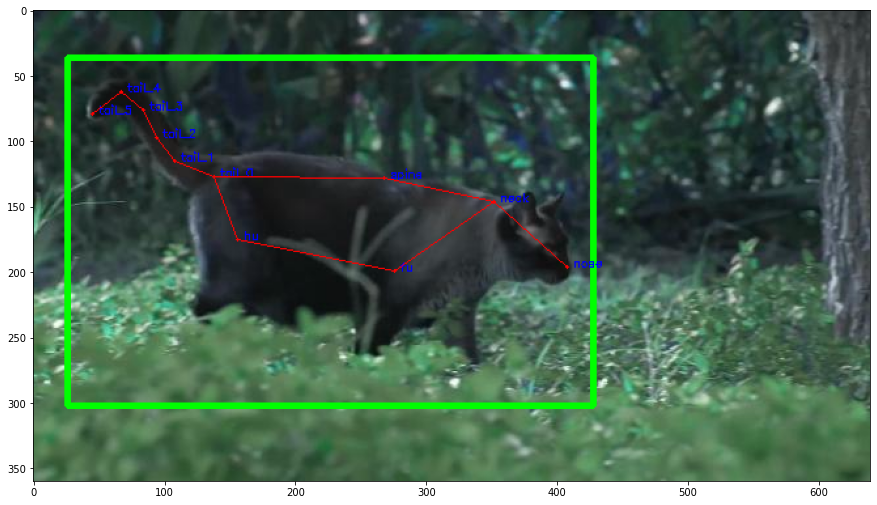

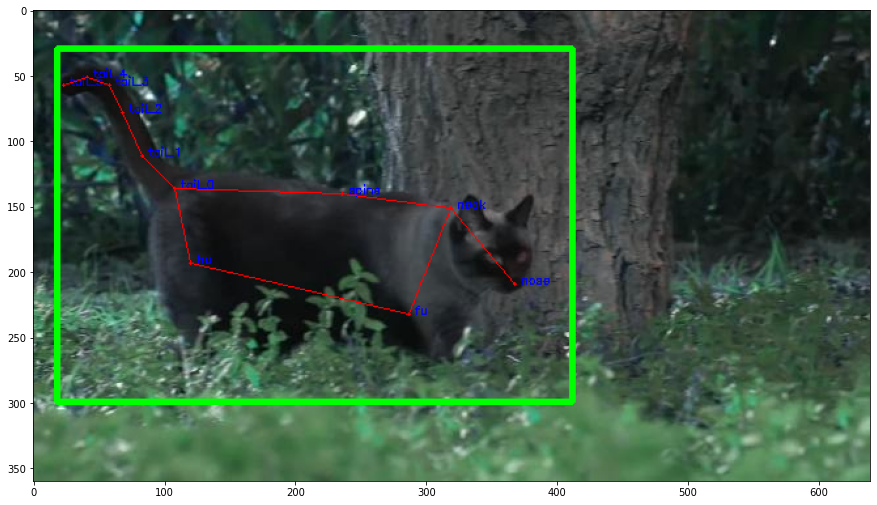

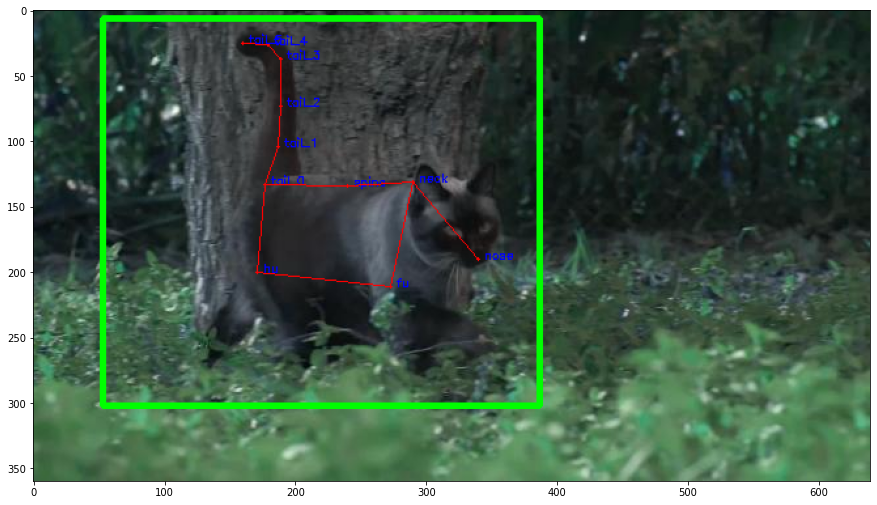

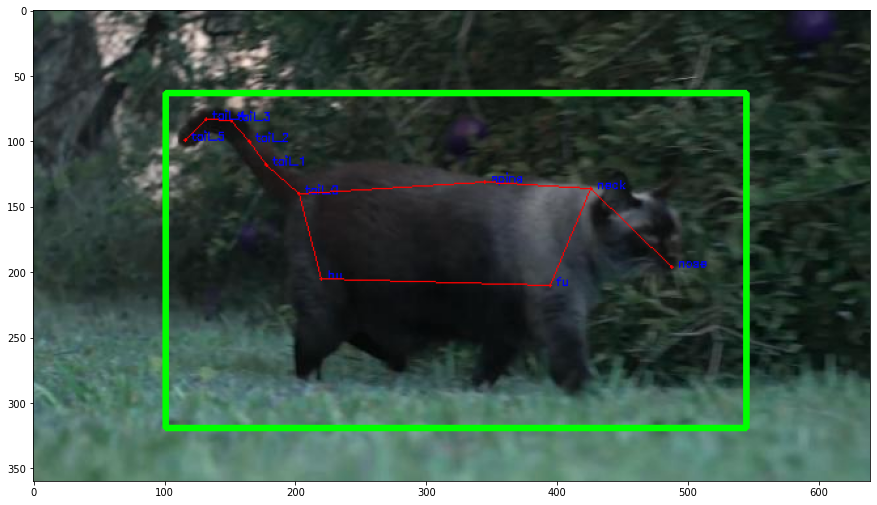

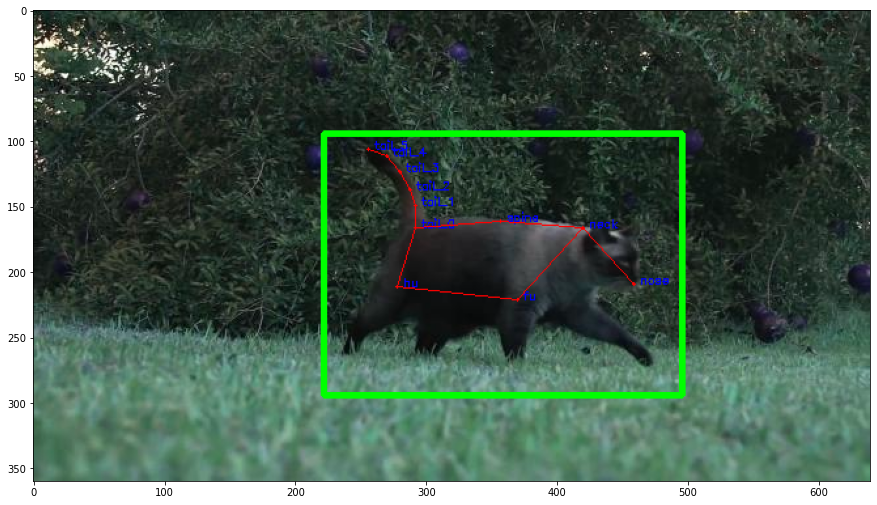

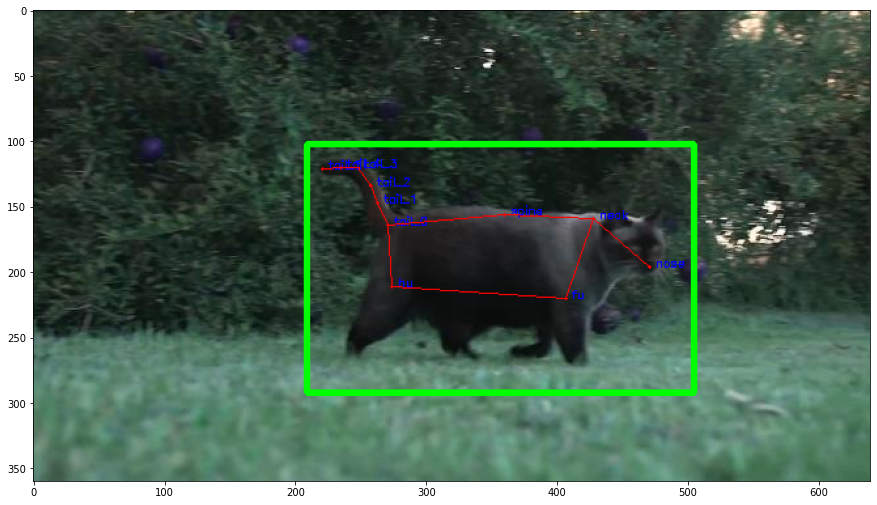

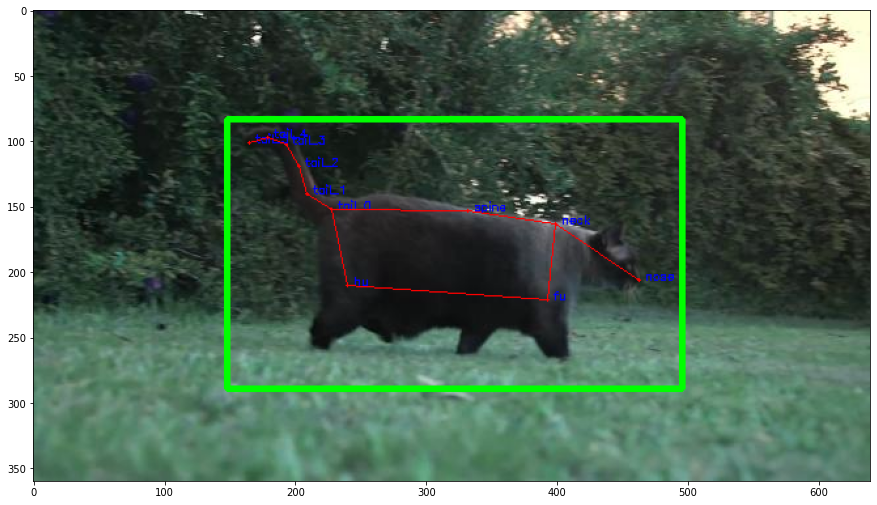

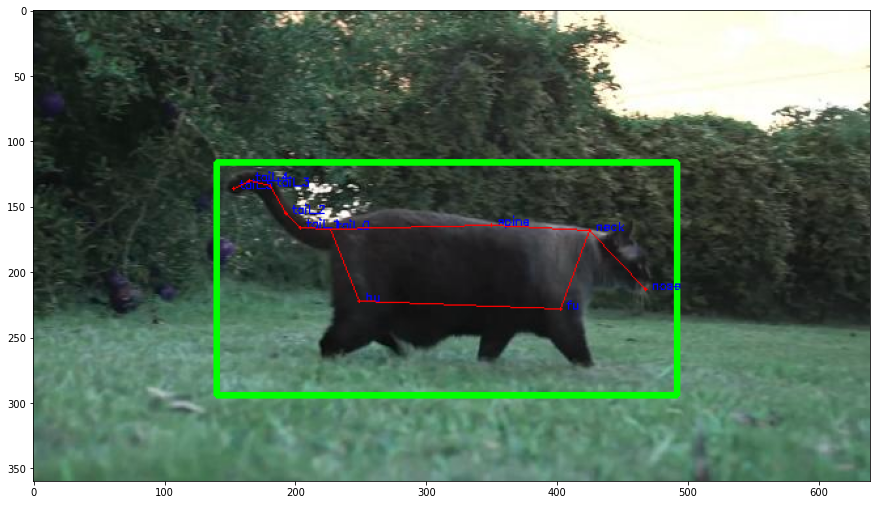

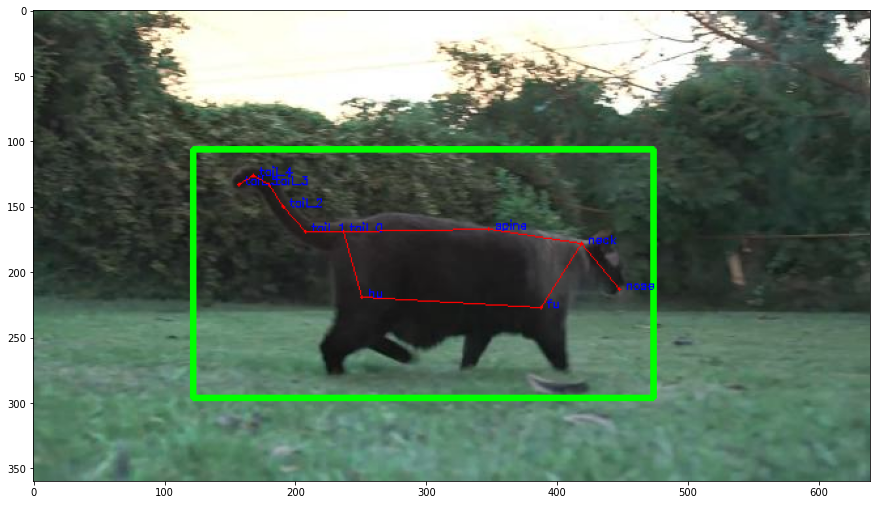

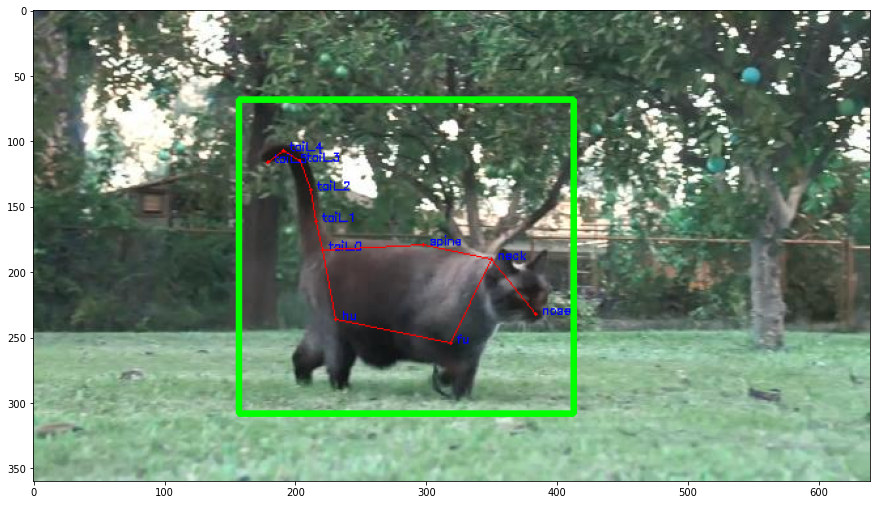

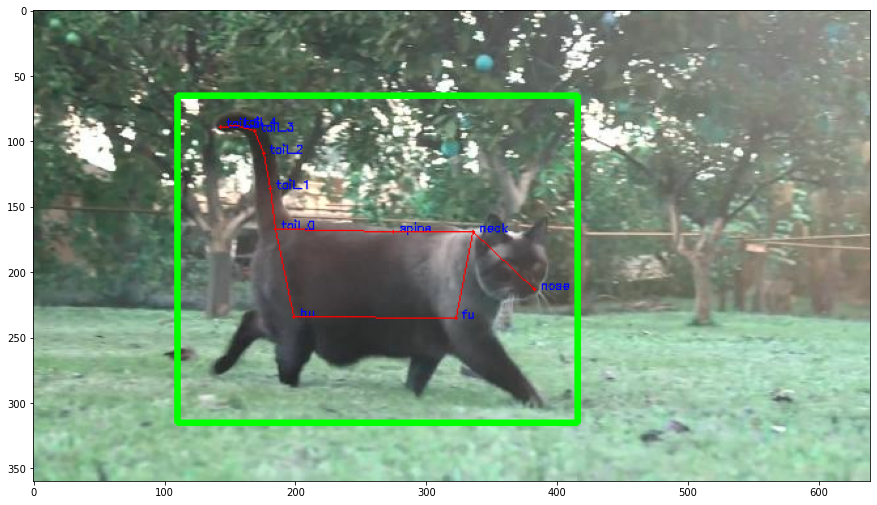

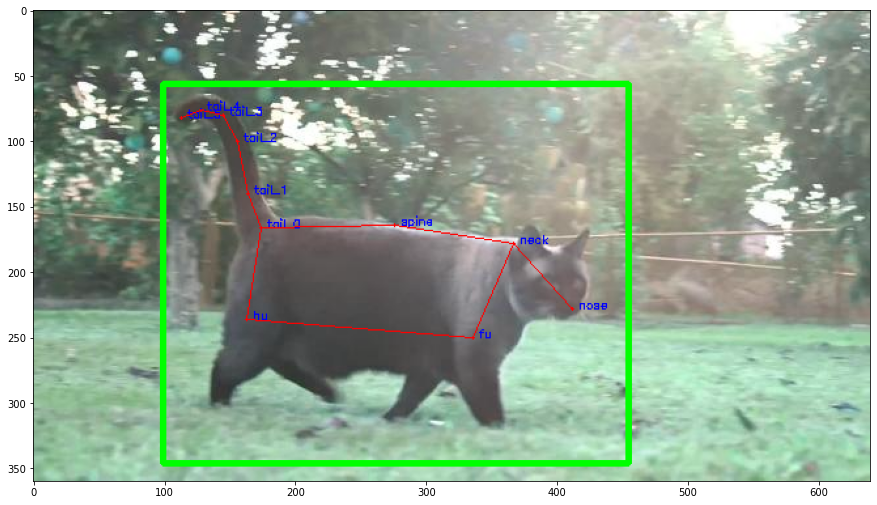

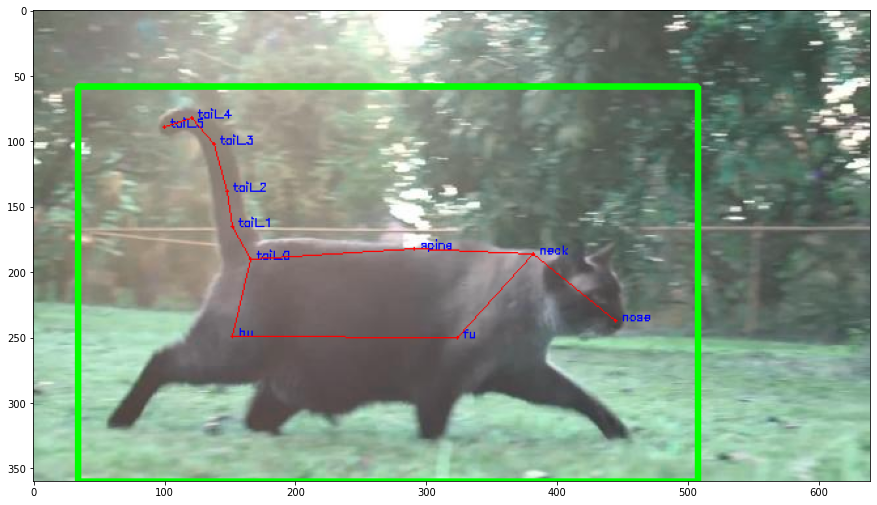

In [ ]:
series = []
for image, annotation in zip(image_path, json_path):
    with open(JSON_PATH + annotation) as fp:
        data = json.load(fp)
        keypoints = [data['keypoints']]
        bboxes = [data['bboxes']]

        visualize_n_save(IMAGE_PATH + image, keypoints, bboxes, save=True)
        r = track_point_coord(keypoints[0], keypoints_classes)
        result = get_angle_array(keypoints[0], keypoints_classes)
        row = pd.Series(result)
        series.append(row)

In [ ]:
df = pd.DataFrame(series)
df

tail_0 <-> fu  tail_0 <-> hu  tail_0 <-> neck  tail_0 <-> nose  \
0       22.479107      64.370250              0.0         9.261731   
1       24.138912      74.045023              0.0        11.616789   
2       40.107838      96.131294              0.0        20.288366   
3       21.058629      76.370866              0.0        12.144114   
4       35.188743     107.281498              0.0        14.439161   
5       24.204225      88.171867              0.0        10.914367   
6       19.013173      74.630009              0.0         9.260564   
7       18.826481      67.909220              0.0        10.516775   
8       18.181078      71.526752              0.0         8.948131   
9       32.816919      76.209061              0.0        13.625460   
10      25.473100      77.438726              0.0        12.320284   
11      23.849724      95.372738              0.0        11.043420   
12      21.855027     104.409639              0.0        10.623110   

    tail_0 <-> spine  tail_0 <-> tail_0  tail_0 <-> tail_1  tail_0 <-> tail_2  \
0           4.632977           5.073705         163.272295         150.786828   
1           2.276408           4.066319         139.066319         128.658607   
2           1.923359           1.013979          69.960415          77.676089   
3           2.598955           1.027617         137.624606         132.503582   
4           4.398705           0.000000          90.000000          97.853313   
5           3.312289           1.824090         113.377034         111.604603   
6           3.129718           3.680622         151.404978         130.827309   
7           1.686551           0.289370         177.799817         160.849335   
8           3.863246           2.831002         177.168998         160.388248   
9           6.079758           3.106027         105.910293         104.176230   
10          0.514190           0.758840          98.111219          99.579220   
11          4.681155           3.557852         114.595363         108.812971   
12          2.601024           1.060912         118.187915         108.032580   

    tail_0 <-> tail_3  tail_0 <-> tail_4  tail_0 <-> tail_5  
0          141.710282         142.599822         157.774133  
1          126.396505         132.312745         141.161571  
2           81.861005          87.915197          97.931403  
3          131.851287         140.214298         153.739552  
4          105.592811         111.801409         120.963757  
5          115.773206         127.465317         137.480379  
6          128.672642         135.378756         144.689628  
7          144.634042         149.461708         157.559638  
8          150.555357         150.900320         158.603256  
9          107.142271         114.647003         125.188214  
10         102.801415         110.916451         119.059596  
11         112.192437         120.629932         129.544648  
12         106.589213         111.558953         122.102313

In [ ]:
df.to_json("angles.json")